In [ ]:
!pip install cirq --pre

In [2]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import recirq.mbl_dtc as dtc_utils

In [3]:
# Variables used across all figures

# define the qubits we'll be using
qubit_locations = [(3, 9), (3, 8), (3, 7), (4, 7), (4, 8), (5, 8), (5, 7), (5, 6), (6, 6), (6, 5), (7, 5), (8, 5),
              (8, 4), (8, 3), (7, 3), (6, 3)]

qubits = [cirq.GridQubit(*idx) for idx in qubit_locations]
num_qubits = len(qubits)

# prepare our DTC circuit list, with 0 through 100 cycles
num_cycles = 100
circuit_list = dtc_utils.symbolic_dtc_circuit_list(qubits=qubits, cycles=num_cycles)

<timed exec>:77: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


CPU times: user 5min 38s, sys: 3.22 s, total: 5min 41s
Wall time: 5min 41s


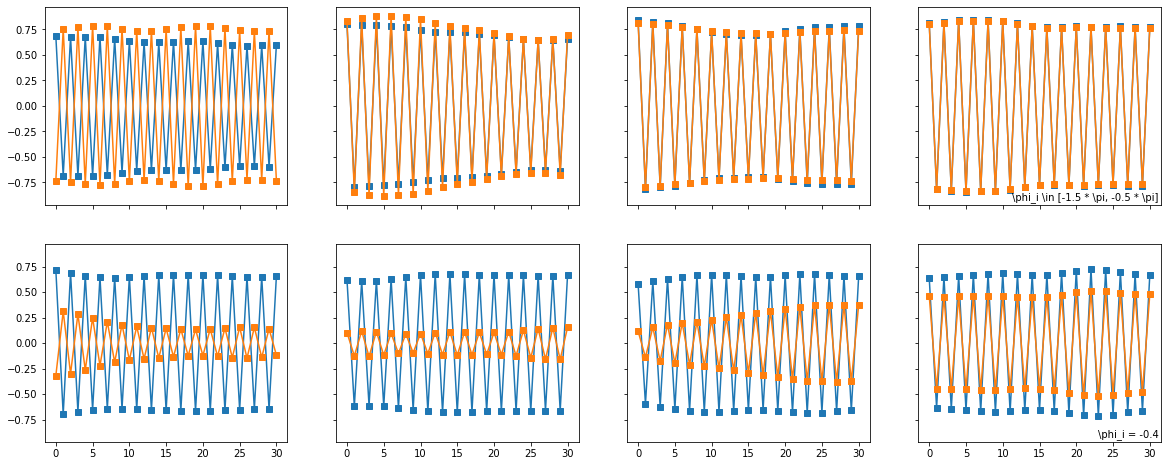

In [4]:
%%time
# Figure 3c

# prepare two initial states to compare
disturb_qubit = 11
polarized_initial_state = [0]*num_qubits
disturbed_polarized_initial_state = list(polarized_initial_state)
disturbed_polarized_initial_state[disturb_qubit] = 1
initial_states = [polarized_initial_state, disturbed_polarized_initial_state]
initial_state_instances = len(initial_states)

# constants for disorder instances and thermalization (g)
disorder_instances = 24
g = 0.94

# expand thermalization constant for each disorder instance
gs = np.full(disorder_instances, g)

# parameters for two-qubit FSim gates
# zeros for theta, zeta, chi
thetas = np.zeros((disorder_instances, num_qubits))
zetas = np.zeros((disorder_instances, num_qubits))
chis = np.zeros((disorder_instances, num_qubits))

# disorder parameters h and phi
local_fields = np.random.uniform(-1.0, 1.0, (disorder_instances, num_qubits))
disordered_phis = np.random.uniform(-1.5*np.pi, -0.5*np.pi, (disorder_instances, num_qubits))

# expand fixed phis for all instances and qubits
fixed_phi = -0.4
fixed_phis = np.full((disorder_instances, num_qubits), fixed_phi)

# prepare subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,8), sharey=True, sharex=True)

for random_phi, row_axes in zip([True, False], axes): 
    # use either random, disordered phis or fixed ones
    if random_phi: 
        phis = disordered_phis
    else: 
        phis = fixed_phis
    # gamma dependent on phis
    gammas = -1/2*phis

    for initial_state in initial_states:
        # expand initial states for each disorder instance
        initial_state_array = np.asarray([initial_state] * disorder_instances)

        # prepare param resolver
        param_resolvers = dtc_utils.dtc_param_resolver_sweep(gs, initial_state_array, local_fields, thetas, zetas, chis, gammas, phis)

        # simulate and get probabilities
        probabilities = np.asarray(list(dtc_utils.simulate_dtc_circuit_list_sweep(circuit_list, param_resolvers, qubits)))
        
        # turn probabilities into polarizations, this time not relative to initial state
        polarizations = dtc_utils.get_polarizations(probabilities, num_qubits, probabilities_axis=2)

        # only consider qubits 11 through 14
        polarizations = polarizations[:, 30:61, 11:15]

        # average over disorder instances
        average_polarizations = np.mean(polarizations, axis=0)

        # plot each qubit's polarizations 
        for axis, qubit_polarizations in zip(row_axes, np.moveaxis(average_polarizations, 1, 0)):
            # plot qubit polarizations by cycle in a subplot
            axis.plot(qubit_polarizations, marker='s', label=''.join(map(str, initial_state)))


# set phi labels
phi_labels = ['\phi_i \in [-1.5 * \pi, -0.5 * \pi]', '\phi_i = -0.4']

# add phi labels
for phi_label, axis in zip(phi_labels, [axes[0][3], axes[1][3]]): 
    fig.text(0.99, 0.01, phi_label, horizontalalignment='right', verticalalignment='bottom', transform=axis.transAxes)

# show plot
fig.show()